In [1]:
with open('DebrisFlow.txt') as f:
    lines = f.readlines()
    
X= []
Y= []
for line in lines:
    a = str.split(line)
    a[0] = float(a[0])
    a[1] = float(a[1])
    X.append(a[0])
    Y.append(a[1])

    
import pyomo.environ as pyo
model= pyo.ConcreteModel()

I = [i for i in range(len(X))]
model.Iset= pyo.Set(initialize= I)

def X_(model, i):
    return X[i]
model.X= pyo.Param(model.Iset, rule= X_)

def Y_(model, i):
    return Y[i]
model.Y= pyo.Param(model.Iset, rule= Y_)

Clusterning Params and Vars 

In [2]:
B = [0,1,2,3]
model.Bset= pyo.Set(initialize= B)

In [3]:
model.dist= pyo.Var(model.Iset, domain= pyo.NonNegativeReals)

In [4]:
model.delta= pyo.Var(model.Iset, model.Bset, domain= pyo.Binary)

In [5]:
M= [6.5 for y in Y]
def M_(model,i):
    return M[i]
model.M= pyo.Param(model.Iset, rule= M_)

In [6]:
model.c = pyo.Var(model.Bset, domain=pyo.NonNegativeReals)
model.d = pyo.Var(model.Bset, domain=pyo.Reals)

Constraints

In [7]:
def const_1(model, i, b):
    return model.Y[i]-(model.c[b]*model.X[i] + model.d[b])<= model.dist[i]+ model.M[i]*(1-model.delta[i,b])
model.const_1= pyo.Constraint(model.Iset, model.Bset, rule= const_1)

In [8]:
def const_2(model, i, b):
    return (model.c[b]*model.X[i] + model.d[b])- model.Y[i]<= model.dist[i]+ model.M[i]*(1-model.delta[i,b])
model.const_2= pyo.Constraint(model.Iset, model.Bset, rule= const_2)

In [9]:
def delta_(model, i):
    return sum(model.delta[i,b] for b in model.Bset)==1
model.const_delta= pyo.Constraint(model.Iset, rule=delta_)

# Ordering constraints

In [10]:
def ord_1(model, i, b):
    if i== I[-1] or b== B[-1]:
        return pyo.Constraint.Skip
    else:
        return model.delta[i+1,b+1]<= model.delta[i,b]+model.delta[i,b+1]
model.const_ord_1= pyo.Constraint(model.Iset, model.Bset, rule=ord_1)

In [11]:
def ord_2(model, i):
    if i== I[-1]:
        return pyo.Constraint.Skip
    else:
         return model.delta[i+1,B[0]]<= model.delta[i,B[0]]
model.const_ord_2= pyo.Constraint(model.Iset, rule= ord_2)

In [12]:
def ord_3(model, i):
    if i== I[-1]:
        return pyo.Constraint.Skip
    else:
        return model.delta[i,B[-1]]<= model.delta[i+1,B[-1]]
model.const_ord_3= pyo.Constraint(model.Iset, rule= ord_3)

# Continuity Variables

In [13]:
model.delta_plus= pyo.Var(model.Iset, model.Bset, domain= pyo.Binary)
model.delta_minus= pyo.Var(model.Iset, model.Bset, domain= pyo.Binary)

In [14]:
model.gama= pyo.Var(model.Bset, domain= pyo.Binary)

In [15]:
M_2= [2*model.X[i]+(10) for i in model.Iset]

def M_two(model,i):
    return M_2[i]
model.M_2= pyo.Param(model.Iset, rule= M_two)

# Clusterwising Parameters & Variables

In [16]:
K= 2

In [17]:
model.Z=  pyo.Var(model.Bset, domain= pyo.Binary)

# Continuity Constraints

In [18]:
def delta_sign(model, i,b):
    return model.delta_plus[i,b]+model.delta_minus[i,b]<=1
model.delta_sign= pyo.Constraint(model.Iset, model.Bset, rule= delta_sign)

In [19]:
def c_d(model, i, b):
    if i== I[-1] or b== B[-1]:
        return pyo.Constraint.Skip
    else:
        return model.delta[i,b]+model.delta[i+1,b+1]+model.gama[b]-2<= model.delta_plus[i,b]+ model.Z[b]
model.c_d= pyo.Constraint(model.Iset, model.Bset, rule=c_d)

In [20]:
def c_e(model, i, b):
    if i== I[-1] or b== B[-1]:
        return pyo.Constraint.Skip
    else:
        return model.delta[i,b]+model.delta[i+1,b+1]+ (1-model.gama[b])-2<= model.delta_minus[i,b]+ model.Z[b]
model.c_e= pyo.Constraint(model.Iset, model.Bset, rule=c_e)

In [21]:
def c_f(model, i, b):
    if i== I[-1] or b== B[-1]:
        return pyo.Constraint.Skip
    else:
        return model.d[b+1]-model.d[b]>= model.X[i]*(model.c[b]-model.c[b+1])-model.M_2[i]*(1-model.delta_plus[i,b])
model.c_f= pyo.Constraint(model.Iset, model.Bset, rule=c_f)

In [22]:
def c_g(model, i, b):
    if i== I[-1] or b== B[-1]:
        return pyo.Constraint.Skip
    else:
        return model.d[b+1]-model.d[b]<= model.X[i+1]*(model.c[b]-model.c[b+1])+model.M_2[i+1]*(1-model.delta_plus[i,b])
model.c_g= pyo.Constraint(model.Iset, model.Bset, rule=c_g)

In [23]:
def c_h(model, i, b):
    if i== I[-1] or b== B[-1]:
        return pyo.Constraint.Skip
    else:
        return model.d[b+1]-model.d[b]<= model.X[i]*(model.c[b]-model.c[b+1])+model.M_2[i]*(1-model.delta_minus[i,b])
model.c_h= pyo.Constraint(model.Iset, model.Bset, rule=c_h)

In [24]:
def c_i(model, i, b):
    if i== I[-1] or b== B[-1]:
        return pyo.Constraint.Skip
    else:
        return model.d[b+1]-model.d[b]>= model.X[i+1]*(model.c[b]-model.c[b+1])-model.M_2[i+1]*(1-model.delta_minus[i,b])
model.c_i= pyo.Constraint(model.Iset, model.Bset, rule=c_i)

# Clustervising Constraints 

In [25]:
def last(model):
    return model.Z[B[-1]]==0
model.last= pyo.Constraint(rule= last)

def clust(model):
    return sum(model.Z[b] for b in model.Bset)== K-1
model.clust= pyo.Constraint(rule= clust)

Objective

In [26]:
def obj(model):
    return sum(model.dist[i] for i in model.Iset)
model.obj= pyo.Objective(rule=obj, sense= pyo.minimize)

Solve and Result

In [27]:
opt = pyo.SolverFactory('glpk') 
result=opt.solve(model,'glpk')

In [28]:
print(pyo.value(model.obj))

54.74967278145457


# Visualization

In [29]:
delta_results= [pyo.value(model.delta[i,b]) for i in model.Iset for b in model.Bset]

In [30]:
Cluster= {}
for b in model.Bset:
    Cluster[b]= {}
    Cluster[b]['X']= []
    Cluster[b]['Y']= []
for b in model.Bset:
    for i in model.Iset:
        if pyo.value(model.delta[i, b]) == 1:
            Cluster[b]['X'].append(model.X[i])
            Cluster[b]['Y'].append(model.Y[i])

In [31]:
C= {}
D= {}
for b in model.Bset:
    C[b]= pyo.value(model.c[b])
    D[b]= pyo.value(model.d[b])

In [32]:
c_results= []
d_results= []
for i in I:
    for b in B:
        if pyo.value(model.delta[i,b])==1:
            c_results.append(C[b])
            d_results.append(D[b])

In [33]:
print(C)
print(D)

{0: 0.0607880672544707, 1: 0.054632540044327, 2: 0.0946960891046729, 3: 0.0677820574028578}
{0: -0.963549827651889, 1: 6.10302951887858, 2: -8.85544021658083, 3: 2.10430337481039}


In [34]:
for b in model.Z:
    print(pyo.value(model.Z[b]))

1.0
0.0
0.0
0.0


In [35]:
import matplotlib.pyplot as plt

In [58]:
#Defining clusters based on the values of Z

X_0= []
for i in model.Iset:
    if pyo.value(model.delta[i,0])==1:
        X_0.append(i)

X_1= I[24:]

t_0= X_0
t_1= X_1
X_0= [X[i] for i in t_0]
X_1= [X[i] for i in t_1]
Y_0= [Y[i] for i in t_0]
Y_1= [Y[i] for i in t_1]

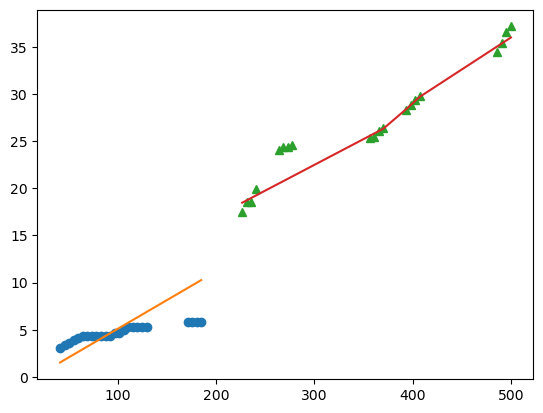

In [59]:
plt.plot([X[i] for i in t_0],[Y[i] for i in t_0],'o')
plt.plot([X[i] for i in t_0], [X[i]*c_results[i]+d_results[i] for i in t_0])
plt.plot([X[i] for i in t_1],[Y[i] for i in t_1],'^')
plt.plot([X[i] for i in t_1], [X[i]*c_results[i]+d_results[i] for i in t_1])
plt.show()

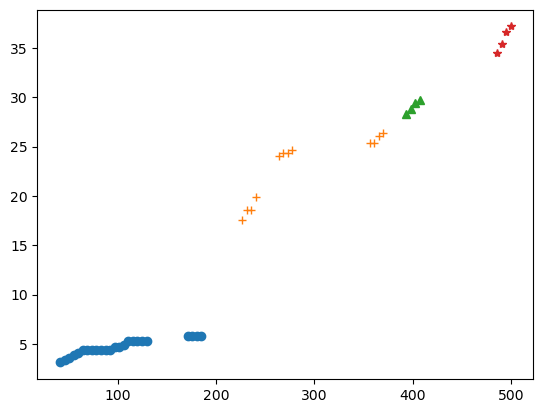

In [60]:
shape= ['o','+','^','*']
count= 0
for b in model.Bset:
    plt.plot(Cluster[b]['X'], Cluster[b]['Y'], shape[count])
    count+= 1
    
plt.show()

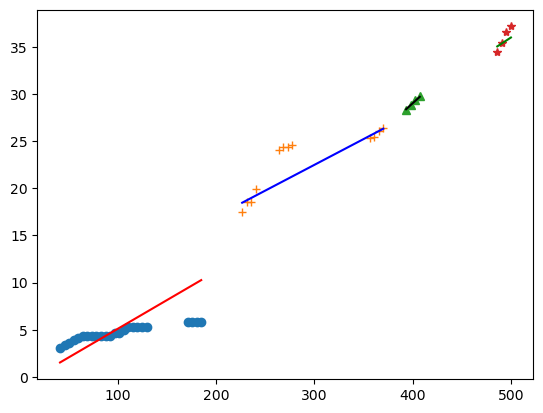

In [61]:
shape= ['o','+','^','*']
color= ['r','b','k','g']
count= 0
for b in model.Bset:
    S= shape[count]+':'+color[count]
    plt.plot(Cluster[b]['X'], Cluster[b]['Y'], shape[count])
    plt.plot(Cluster[b]['X'], [x*C[b]+D[b] for x in Cluster[b]['X']],color[count])
    count+= 1
    
plt.show()